In [1]:
###############
# some imports
###############
import ezdxf
import itertools
import k3d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import meshio
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import pynoddy
from scipy.interpolate import griddata
import scipy.interpolate as interp
import sys, os
import subprocess
from shutil import copyfile
import time
import vtk
from vtkplotter import *
import PriorModelPlottingUtilty as util
util.importModulesAndSetup()

##############
# Some more imports after file fixes 
##############

import pynoddy.history
import pynoddy.experiment
import pynoddy.events

## Calculate the model

In [2]:
# Model with five faults three layers 
modelfile = 'ThreeLayerTrenton.his'

#Alter the mesh size if desiring to speed up the process. Recommended size is 100
output_name = 'noddy_out'
cubesize = 100
includeGravityCalc = 0
xy_origin=[317883,4379646, 1200-5000]

settings.embedWindow('itkwidgets') #you can also choose to change to itkwidgets, k3d, False (popup)

plot = Plotter(axes=1, bg='white', interactive=1)

H1 = pynoddy.history.NoddyHistory(modelfile)
points = util.CalculatePlotStructure(H1,plot, includeGravityCalc, cubesize = cubesize, xy_origin=xy_origin)
plot.show(viewup='z')

b''
Finished calculating model
Calculation time took 27.46236801147461 seconds
Parsing time took 7.232702970504761 seconds
The number of triangle elements (cells/faces) is: 251921
Convert 2 VTK time took 0.702960729598999 seconds


Viewer(cmap='jet', geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_point…

## Get some information about the model

In [3]:
N1 = pynoddy.output.NoddyOutput(output_name)

[maxX, maxY, maxZ] = np.max(points, axis=0)
[minX, minY, minZ] = np.min(points, axis=0)

x = np.linspace(minX, maxX, N1.nx, dtype=np.float32)
y = np.linspace(minY, maxY, N1.ny, dtype=np.float32)
z = np.linspace(minZ, maxZ, N1.nz, dtype=np.float32)

delx = x[1]-x[0]
dely = y[1]-y[0]
delz = z[1]-z[0]

print("The model has an extent of %.0f m in x-direction, with %d cells of width %.0f m" %
      (maxX, N1.nx, delx))
print("The model has an extent of %.0f m in y-direction, with %d cells of width %.0f m" %
      (maxY, N1.ny, dely))
print("The model has an extent of %.0f m in z-direction, with %d cells of width %.0f m" %
      (maxZ, N1.nz, delz))

The model has an extent of 329883 m in x-direction, with 44 cells of width 279 m
The model has an extent of 4386646 m in y-direction, with 48 cells of width 149 m
The model has an extent of 1200 m in z-direction, with 20 cells of width 247 m


## Changing around the model parameters

In [4]:
start = time.time()
H1 = pynoddy.history.NoddyHistory(modelfile)

H1.events[3].properties['Dip'] = 40
H1.events[3].properties['X'] = 10000
H1.events[4].properties['Slip'] = 400
H1.events[5].properties['Dip'] = 90
H1.events[5].properties['X'] = 9000
H1.events[2].properties['Rotation'] = 40
H1.events[3].properties['Dip Direction'] = 26
H1.events[3].properties['Slip'] = 400

plot = Plotter()

includeGravityCalc = 1
util.CalculatePlotStructure(H1,plot, includeGravityCalc, cubesize = cubesize, xy_origin=xy_origin)
end = time.time()
print('Calculation time took '+str(end - start) + ' seconds')

plot.show()

b''
Finished calculating model
Calculation time took 33.25487756729126 seconds
Parsing time took 8.138769626617432 seconds
The number of triangle elements (cells/faces) is: 272737
Convert 2 VTK time took 0.765449047088623 seconds
Calculation time took 44.361682653427124 seconds


Viewer(cmap='jet', geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_point…

## Some 2D plots

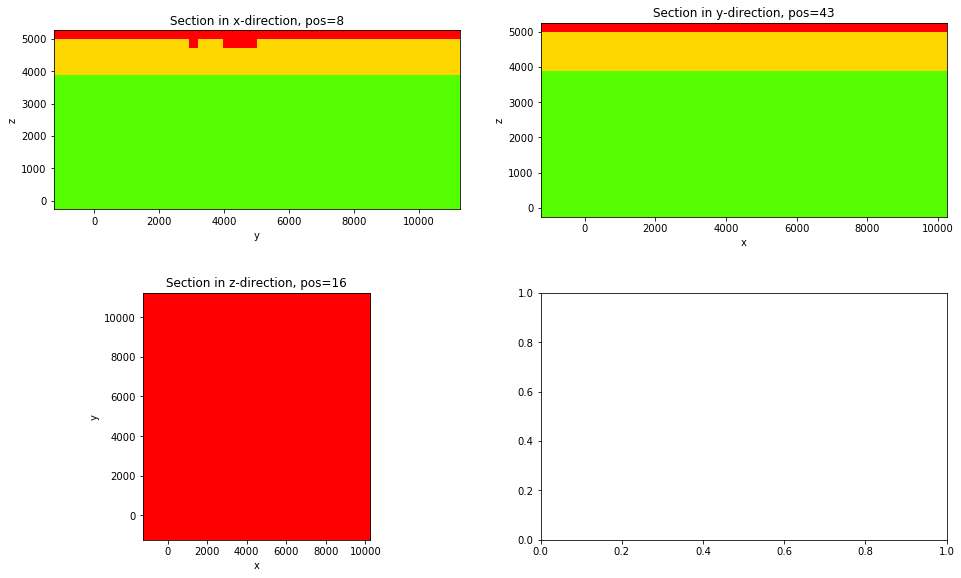

In [5]:
xslice = int(0.2*N1.nx)
yslice = int(0.9*N1.ny)
zslice = int(0.8*N1.nz)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 10))

## X slice
ax = axs[0,0]
N1.plot_section('x', position = xslice, ax = ax, cmap='prism')

## Y slice
ax = axs[0,1]
N1.plot_section('y', position = yslice, ax = ax, cmap='prism')

## Z slice
ax = axs[1,0]
N1.plot_section('z', position = zslice, ax = ax, cmap='prism')

### With Gravity

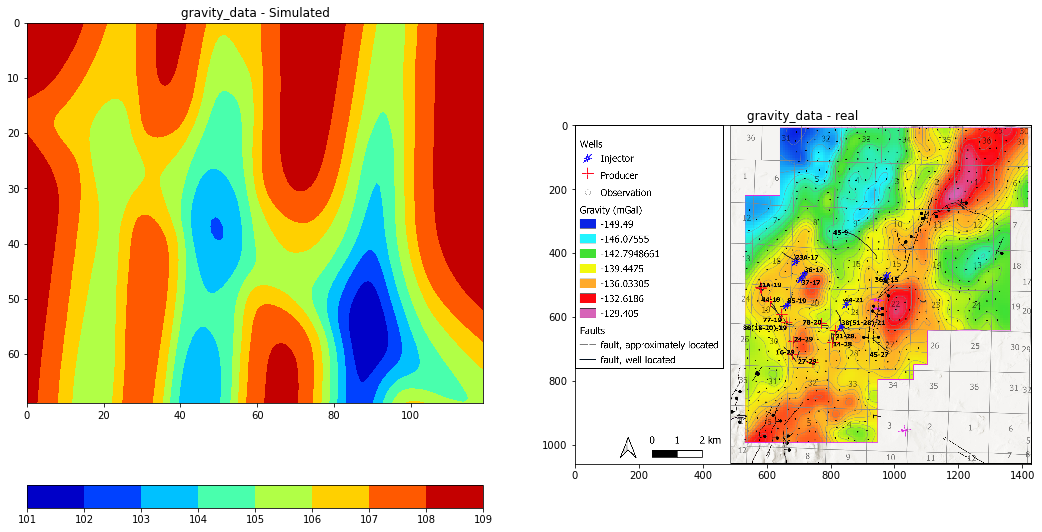

In [6]:
fileGeo = 'temp_noddy_out'

geophys = pynoddy.output.NoddyGeophysics(fileGeo)
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(121)
# imshow(geophys.grv_data, cmap = 'jet')
cf = ax.contourf(geophys.grv_data, cmap = 'jet')
cbar = plt.colorbar(cf, orientation = 'horizontal')
ax.set_title('gravity_data - Simulated')
plt.gca().invert_yaxis()

ax = fig.add_subplot(122)
img = mpimg.imread('GravityReal.png')
ax.set_title('gravity_data - real')
ax.imshow(img)

## Comparing granite top layers

In [16]:
Wells = pd.read_csv('WellNamesPaths.csv')
filterV = (Wells['X_m']>minX+delx) & (Wells['Y_m']>minY+dely) &  (Wells['Z_m']>minZ+delz) & (Wells['X_m']<maxX-delx) & (Wells['Y_m']<maxY-dely) & (Wells['Z_m']<maxZ-delz)
Wells = Wells[filterV]

output_name = 'temp_noddy_out'
N1 = pynoddy.output.NoddyOutput(output_name)
lithology = N1.block
    
WellboreColors = util.get_wellbore_voxels_from_paths2(lithology, Wells['X_m'], Wells['Y_m'], Wells['Z_m'], [minX, maxX], [minY, maxY], [minZ, maxZ], [delx, dely, delz])
Wells['Colors'] = WellboreColors

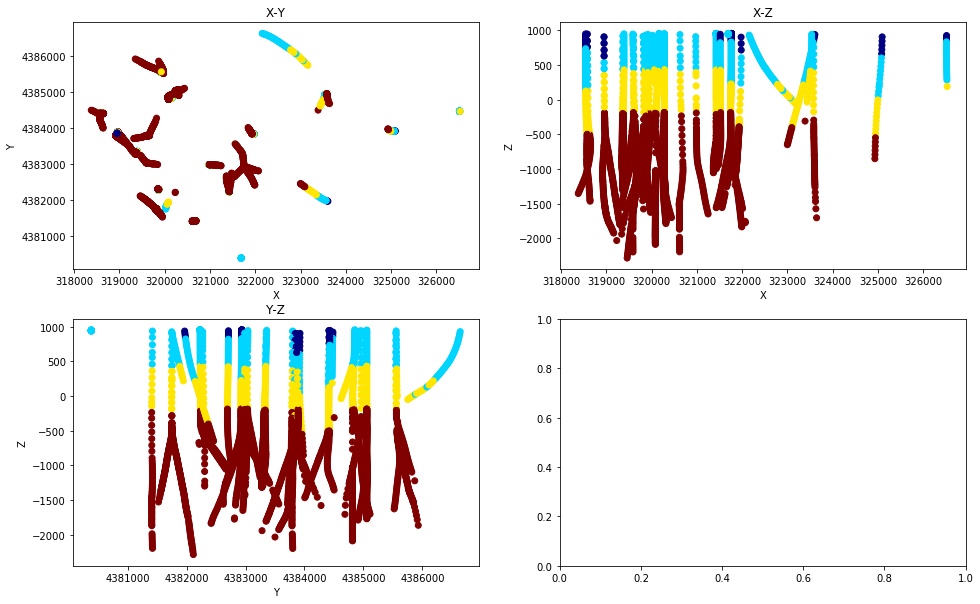

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 10))

ax = axs[0,0]
ax.scatter(Wells['X_m'], Wells['Y_m'], c=Wells['Colors'], cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('X-Y')

ax = axs[0,1]
ax.scatter(Wells['X_m'], Wells['Z_m'], c=Wells['Colors'], cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('X-Z')

ax = axs[1,0]
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_title('Y-Z')
ax.scatter(Wells['Y_m'], Wells['Z_m'], c=Wells['Colors'], cmap='jet')

## Creating multiple realizations using a prior uncertainty table

In [10]:
PriorStructuralModelTable = pd.read_csv('PriorUncertaintyTable.csv')
PriorStructuralModelTable.head(20)

,Property,Parameter,Normal fault dipping East,Small normal Fault dipping west,Small normal Fault dipping east,Normal Fault dipping west
0,Dip,Prior distribution type,Uniform,Uniform,Uniform,Uniform
1,Dip,Prior distribution paramter 1,50,60,40,50
2,Dip,Prior distribution paramter 2,90,90,70,90
3,Slip,Prior distribution type,Uniform,Uniform,Uniform,Uniform
4,Slip,Prior distribution paramter 1,600,500,400,400
5,Slip,Prior distribution paramter 2,900,700,600,600
6,X,Prior distribution type,Uniform,Uniform,Uniform,Uniform
7,X,Prior distribution paramter 1,5000,5000,2000,1000
8,X,Prior distribution paramter 2,7000,7000,4000,3000
9,Y,Prior distribution type,Uniform,Uniform,Uniform,Uniform


## We will use a slightly different model

In [11]:
# Model with five faults three layers 
modelfile = 'Scen1_Fork2.his'

#Alter the mesh size if desiring to speed up the process. Recommended size is 100
output_name = 'noddy_out'
cubesize = 100
includeGravityCalc = 0
xy_origin=[317883,4379646, 1200-4000]

settings.embedWindow('itkwidgets') #you can also choose to change to itkwidgets, k3d, False (popup)

plot = Plotter(axes=1, bg='white', interactive=1)

H1 = pynoddy.history.NoddyHistory(modelfile)
points = util.CalculatePlotStructure(H1,plot, includeGravityCalc, cubesize = cubesize, xy_origin=xy_origin)
plot.show(viewup='z')

b''
Finished calculating model
Calculation time took 12.028461933135986 seconds
Parsing time took 7.763854026794434 seconds
The number of triangle elements (cells/faces) is: 264028
Convert 2 VTK time took 0.7654473781585693 seconds


Viewer(cmap='jet', geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_point…

## Generate 5 realizations

In [12]:
nrealizations = 5
baseInputFile = 'Scen1_Fork2.his'

folder = 'Scenario1'
util.sampleMultiplePriorModelParameters(PriorStructuralModelTable, baseInputFile, nrealizations, folder)
util.calcMultipleHistoryFiles(nrealizations, folder, outputoption = 'ALL', cubesize = 100)

b''
Finished calculating model
The number of triangle elements (cells/faces) is: 266479
b''
Finished calculating model
The number of triangle elements (cells/faces) is: 286645
b''
Finished calculating model
The number of triangle elements (cells/faces) is: 265229
b''
Finished calculating model
The number of triangle elements (cells/faces) is: 273095
b''
Finished calculating model
The number of triangle elements (cells/faces) is: 273435


## Create plots of the realizations

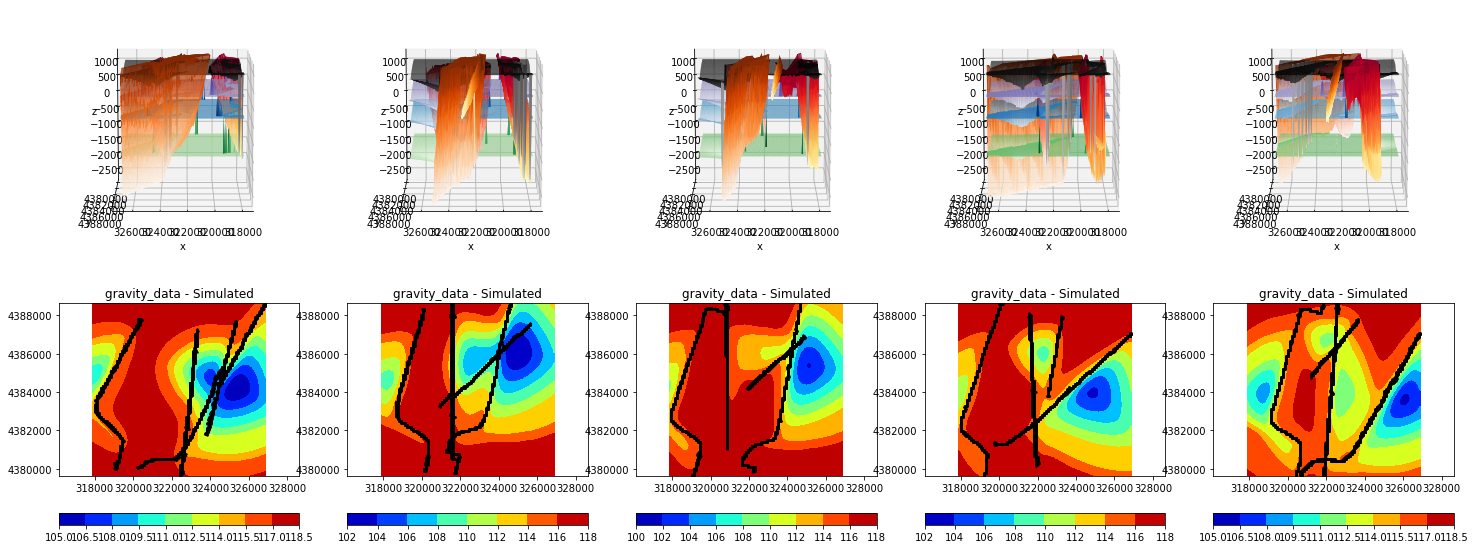

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(25,10))

nRealizations = 5
for r in range(nRealizations):
    ax = fig.add_subplot(2,nRealizations,r+1, projection='3d')

    inputfile = folder+'/realization_'+str(r)
    data = np.loadtxt(inputfile+'pointdata.csv', delimiter=',')
    CatCodesCorrect = data[:,3]
    points = data[:,0:3]
    # Data for three-dimensional scattered points
    Surfaces = np.unique(CatCodesCorrect)
    nSurfaces = len(Surfaces)
    cmapNames = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

    for i in range(nSurfaces):
        filterS= CatCodesCorrect==Surfaces[i]
#        ax.scatter3D(points[filterS,0], points[filterS,1], points[filterS,2], c=points[filterS,1], cmap=cmapNames[i]);
        ax.plot_trisurf(points[filterS,0], points[filterS,1], points[filterS,2],cmap=cmapNames[i]);
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(azim=90, elev=10)

    fileGeo = inputfile+'_output'
    geophys = pynoddy.output.NoddyGeophysics(fileGeo)
    
    if(r==0):
        [maxX, maxY, maxZ] = np.max(points, axis=0)
        [minX, minY, minZ] = np.min(points, axis=0)
        x = np.linspace(minX, maxX, np.shape(geophys.grv_data)[1], dtype=np.float32)
        y = np.linspace(maxY, minY, np.shape(geophys.grv_data)[0], dtype=np.float32)
        xx, yy = np.meshgrid(x, y, indexing='xy')

    ax = fig.add_subplot(2,nRealizations,r+1+nRealizations)
    inputfile = folder+'/realization_'+str(r)
    fileGeo = inputfile+'_output'
    geophys = pynoddy.output.NoddyGeophysics(fileGeo)
    ax.imshow(geophys.grv_data, cmap = 'jet')
    cf = ax.contourf(xx, yy, geophys.grv_data, cmap = 'jet', zorder=0)
    cbar = plt.colorbar(cf, orientation = 'horizontal')
    filterTop = points[:,2]>maxZ-float(cubesize)*1.2
    ax.scatter(points[filterTop,0], points[filterTop,1], zorder=100, s=2, c='k')
    ax.set_title('gravity_data - Simulated')
    ax.axis('equal')
    ax.set_xlim([np.min(xx), np.max(xx)])
    ax.set_ylim([np.min(yy), np.max(yy)])
    #plt.gca().invert_yaxis()

## There is also the option to sample a single model

In [14]:
start = time.time()
baseInputFile = 'Scen1_Fork2.his'
OutputfileName = 'Scen1_Fork2_rev.his'
H1 = util.sampleSinglePriorModelParameters(PriorStructuralModelTable, baseInputFile, OutputfileName)

plot = Plotter()

xy_origin=[317883,4379646, 1200-4000]
includeGravityCalc = 0
util.CalculatePlotStructure(H1,plot, includeGravityCalc, cubesize = 100, xy_origin=xy_origin)
end = time.time()
print('Calculation time took '+str(end - start) + ' seconds')
plot.show(viewup='z')

b''
Finished calculating model
Calculation time took 13.309443473815918 seconds
Parsing time took 8.060626983642578 seconds
The number of triangle elements (cells/faces) is: 280105
Convert 2 VTK time took 0.8591811656951904 seconds
Calculation time took 24.11943769454956 seconds


Viewer(cmap='jet', geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_point…

In [15]:
import importlib
importlib.reload(util)

<module 'PriorModelPlottingUtilty' from 'C:\\Users\\ahinoamp\\Downloads\\BinderExercise-master\\BinderExercise-master\\PriorModelPlottingUtilty.py'>